# Mistral test


In [ ]:
import pandas as pd
from mistralai import Mistral

from mistral_key import key

api_key = key
model = "mistral-small-2409"

client = Mistral(api_key=api_key)

context = "Shipping costs 5€ in the EU, 10€ outside of the EU in Europe, 15€ to the US and Canada and 20€ everywhere else."

question = 'How much is shipping to Somalia?'

prompt = f"""
Context information is below.
---------------------
{context}
---------------------
You are a shop assistant. Be polite with the customer. Don't give any explanation. Reply briefly.
Given the context information and not prior knowledge, answer the query. 
Query: {question}
Answer:
"""

chat_response = client.chat.complete(
    model=model,
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ]
)
ans = chat_response.choices[0].message.content
print(ans)

In [ ]:
prompt_template = """
    You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
    Your task is to analyze the relevance of the generated answer to the given question.
    Based on the relevance of the generated answer, you will classify it
    as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

    Here is the data for evaluation:

    Question: {question}
    Generated Answer: {answer}

    Please analyze the content and context of the generated answer in relation to the question
    and provide your evaluation in parsable JSON without using code blocks:

    {{
      "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
      "Explanation": "[Provide a brief explanation for your evaluation]"
    }}
    """.strip()

prompt_eval = prompt_template.format(question=question, answer=ans)
chat_response_eval = client.chat.complete(
    model=model,
    messages=[
        {
            "role": "user",
            "content": prompt_eval,
        },
    ]
)
eval_ans = chat_response_eval.choices[0].message.content
print(eval_ans)

# Ground truth generation


In [ ]:
questions_path = "data/questions.json"
import json

# Open and load the JSON file
with open(questions_path, 'r') as file:
    questions = json.load(file)

questions

In [ ]:
import hashlib

docs = questions['questions']


def generate_document_id(doc):
    combined = f"{doc['question']}-{doc['answer'][:10]}"
    hash_object = hashlib.md5(combined.encode())
    hash_hex = hash_object.hexdigest()
    document_id = hash_hex[:8]
    return document_id


for doc in docs:
    doc['id'] = generate_document_id(doc)

pd.DataFrame(docs).to_csv('data/questions-raw.csv', index=False)


In [ ]:
prompt_template = """
Emulate a client who is planning to buy at our shop.
Formulate 5 questions this client might ask based on a FAQ record. The record
should contain the answer to the questions, and the questions should be complete and not too short.
If possible, use as fewer words as possible from the record. 

The record:

question: {question}
answer: {answer}

Provide the output in parsable list:

["question1", "question2", ...]
""".strip()

In [ ]:
def generate_question(doc):
    prompt = prompt_template.format(**doc)

    chat_response = client.chat.complete(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ]
    )
    ans = chat_response.choices[0].message.content
    return ans

In [ ]:
import time
from tqdm.auto import tqdm

gen_questions = {}

for doc in tqdm(docs[:1]):
    q = generate_question(doc)
    gen_questions[doc['id']] = json.loads(q)
    time.sleep(6)

In [ ]:
final = []
for doc_id, questions in gen_questions.items():
    for question in questions:
        final.append((doc_id, question))


In [ ]:
import pandas as pd

df_questions = pd.DataFrame(final, columns=['doc_id', 'question'])
# df_questions.to_csv("data/ground_truth.csv", index=False)


In [ ]:
df_questions

# RAG Evaluation

In [ ]:
user_question = "How much is shipping to Somalia"

In [ ]:
def preprocess_context(raw_context):
    s = ""
    for c in raw_context:
        s += c["_source"]["answer"]

    return s


from app.db_ops import query_elasticsearch

# from app.rag import get_context, preprocess_context

raw_context = query_elasticsearch(question)
context = preprocess_context(raw_context)


In [ ]:
context

In [ ]:
def generate_answer(question, context):
    client = Mistral(api_key=api_key)

    prompt = f"""
    You are a shop assistant. Reply briefly. Give a simple explanation. 
    Given the context information and not prior knowledge, answer the query. 
    Query: 
    ```
    {question}
    ```
    Context:     
    ```
    {context}
    ```
    Answer:
    """
    print(prompt)

    chat_response = client.chat.complete(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )
    ans = chat_response.choices[0].message.content
    print(ans)
    return ans, chat_response


ans, meta = generate_answer(user_question, context)

In [ ]:
ans

In [ ]:
import numpy as np


def cosine_similarity(v_original_np, v_llm_np):
    # Compute the dot product
    dot_product = np.dot(v_llm_np, v_original_np)

    # Compute the magnitudes (norms) of the vectors
    magnitude_v_original = np.linalg.norm(v_original_np)
    magnitude_v_llm = np.linalg.norm(v_llm_np)

    cosine_similarity = dot_product / (magnitude_v_original * magnitude_v_llm)

    return cosine_similarity

In [ ]:
from time import sleep
import pandas as pd

raw_question = []
raw_answer = []
llm_answer = []

questions = pd.read_csv('../data/questions-raw.csv')

In [ ]:
for _, row in questions.iterrows():
    q = row['question']
    a = row['answer']
    
    # print(q)
    raw_context = query_elasticsearch(q)
    context = preprocess_context(raw_context)
    ans, meta = generate_answer(q, context)
    raw_question.append(q)
    raw_answer.append(a)
    llm_answer.append(ans)
    sleep(5)


In [ ]:
from sentence_transformers import SentenceTransformer

cosine_sim = []
model = SentenceTransformer("multi-qa-distilbert-cos-v1")

for a, llm_a in zip(raw_answer, llm_answer):
    a_vector = model.encode(a)
    llm_vector = model.encode(llm_a)
    cosine_sim.append(cosine_similarity(a_vector, llm_vector))

In [ ]:
cosine_sim

array([[<Axes: title={'center': '0'}>]], dtype=object)

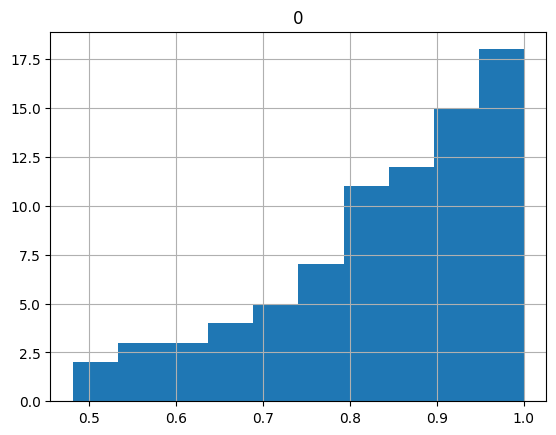

In [29]:
import matplotlib.pyplot as plt
pd.DataFrame(cosine_sim).hist(bins=10)